In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from glob import glob
import xesmf as xe
import cmocean
import datetime
import sys
sys.path.append('../')
from utils import *
from numerics import *
from load import *

from dask.diagnostics import ProgressBar
from dask.distributed import LocalCluster, Client
import gc
cluster = LocalCluster(n_workers=20, threads_per_worker=1, memory_limit='auto')
client  = Client(cluster,asynchronous=True)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 20
Total threads: 20,Total memory: 52.43 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41613,Workers: 20
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 52.43 GiB
Comm: tcp://127.0.0.1:42713,Total threads: 1
Dashboard: http://127.0.0.1:35532/status,Memory: 2.62 GiB
Nanny: tcp://127.0.0.1:34589,


---
### CHECK SPINUP

In [38]:
status = pd.read_csv('data/crocod0_status.out', index_col=1, sep=' ')[::24]
status.index = [pd.Timedelta(days=d)+pd.to_datetime('1949-12-31') for d in status.index]
status

,STEP,KINETIC_ENERGY,POTENTIAL_ENERGY,TOTAL_ENERGY,NET_VOLUME
1999-01-01 00:00:00.000000000,0,0.001388,48.520931,48.522319,8.513361e+140
1999-01-01 01:00:00.287999744,24,0.001412,48.520851,48.522263,8.513361e+140
1999-01-01 01:59:59.712000256,48,0.001414,48.520403,48.521817,8.513361e+140
1999-01-01 03:00:00.000000000,72,0.001413,48.519667,48.521080,8.513361e+140
1999-01-01 04:00:00.287999744,96,0.001412,48.518653,48.520065,8.513359e+140
...,...,...,...,...,...
2011-09-30 19:32:30.335999744,2681749,0.001967,49.237213,49.239180,8.513293e+140
2011-09-30 20:32:29.760000000,2681773,0.001964,49.237873,49.239837,8.513294e+140
2011-09-30 21:32:30.048000000,2681797,0.001961,49.238523,49.240484,8.513295e+140
2011-09-30 22:32:30.335999744,2681821,0.001958,49.239163,49.241122,8.513295e+140


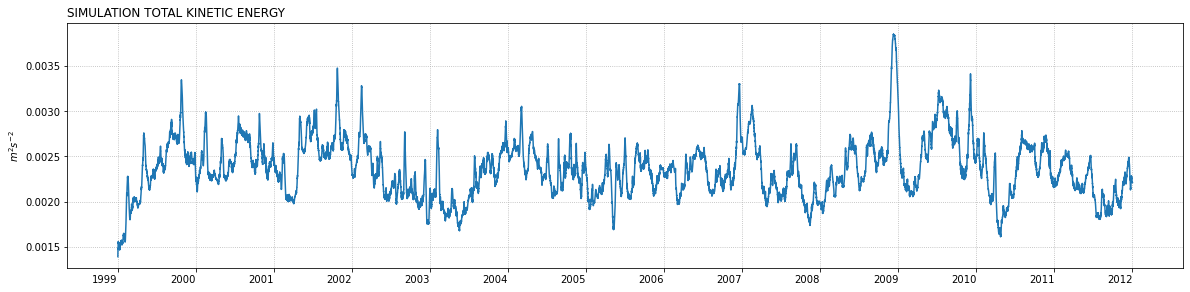

In [54]:
status.KINETIC_ENERGY.plot(figsize=(20,5))
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.grid(True, ls=":")
ax.set_title('SIMULATION TOTAL KINETIC ENERGY', loc='left')
ax.set_ylabel('$m^2s^{-2}$')
ax.tick_params(axis='x', rotation=0)

---

### SEA SURFACE TEMPERATURE

In [7]:
ostia = xr.open_dataset('~/storage/SST_CLIMATOLOGY_OSTIA.nc').analysed_sst
ostia = ostia.sel(lon=slice(-76,-70),lat=slice(-34,-27))

In [5]:
son = (ostia.dayofyear>=244)&(ostia.dayofyear<=334)
djf = (ostia.dayofyear<=365)&(ostia.dayofyear>=335)|((ostia.dayofyear>=1)&(ostia.dayofyear<=59))
mam = (ostia.dayofyear>=60)&(ostia.dayofyear<=151)
jja = (ostia.dayofyear>=152)&(ostia.dayofyear<=243)

ostia_season = [ostia.where(x).mean('dayofyear') for x in [djf, mam, jja, son]]
ostia_season = xr.concat(ostia_season,'season')
ostia_season.coords['season']=['DJF','MAM','JJA','SON']

In [17]:
paths = glob('data/DESALADORAS_RUND0/crocod0_avg_*')[24:]
control = xr.open_mfdataset(paths, parallel=True)

sst = control.temp.isel(s_rho=-1).compute()
sst = sst.where(sst>0)
sst = fix_crocotime(sst, YORIG='1949-12-31 00:00:00')

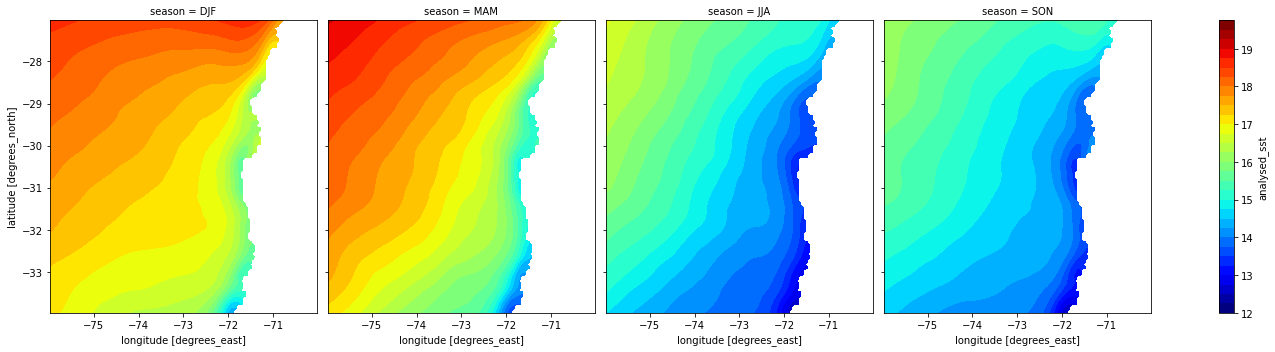

In [37]:
ostia_season.plot.contourf(col='season', figsize=(20,5), cmap='jet', levels=np.arange(12,20,0.25))

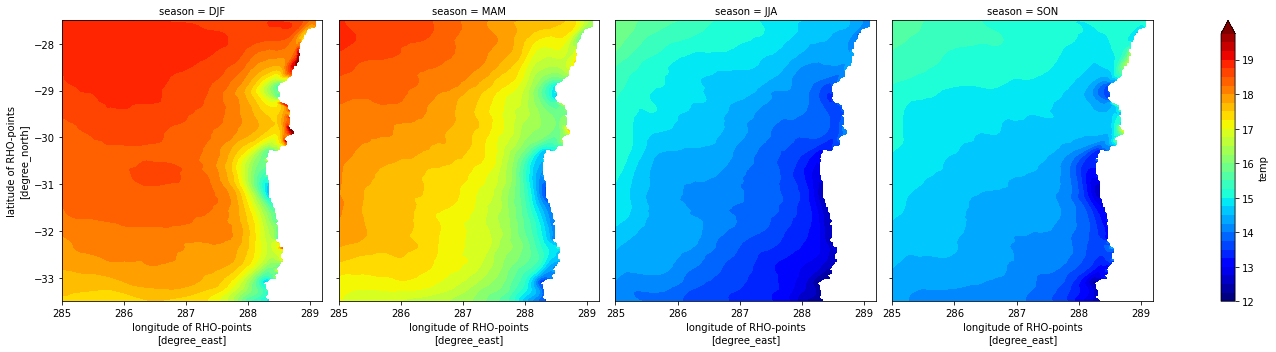

In [35]:
sst.groupby('time.season').mean().sel(season=['DJF','MAM','JJA','SON']).plot.contourf(col='season', figsize=(20,5), cmap='jet', levels=np.arange(12,20,0.25), x='lon_rho', y='lat_rho')

In [69]:
sstcroco_coquimbo = sst.sel(xi_rho=132, eta_rho=152, method='nearest').to_series()
sstcroco_coquimbo.index = sstcroco_coquimbo.index - pd.Timedelta(hours=12, minutes=1, seconds=15)
sst_coquimbo      = pd.read_csv('~/storage/TSM_Coquimbo.csv', index_col=0, parse_dates=True)
sst_coquimbo      = sst_coquimbo['TSM[°C]'].resample('d').mean().loc["2001":"2011"]

Text(0.0, 1.0, 'MBIAS: -0.439 ; RMSE: 1.093 ; r: 0.871')

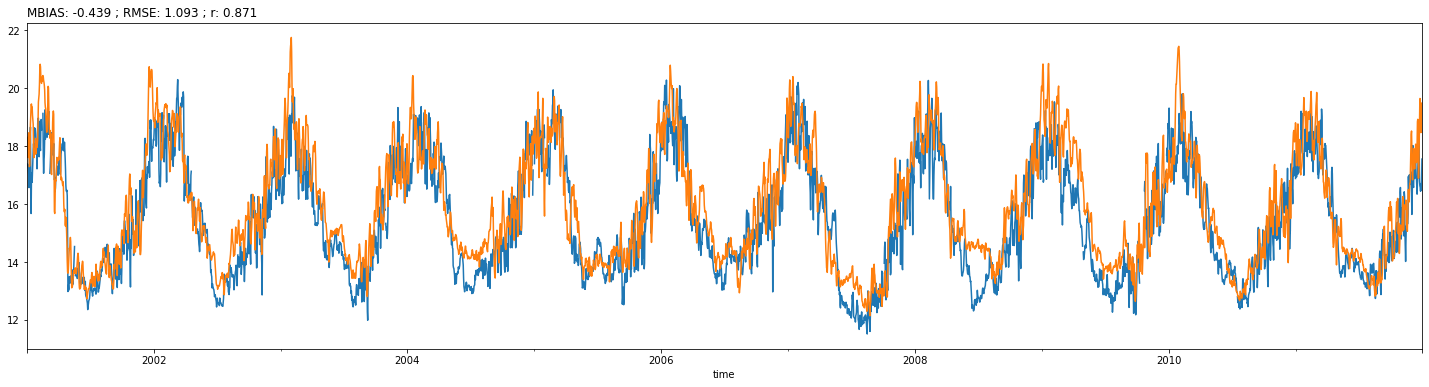

In [101]:
from scipy.stats import pearsonr
fig, ax = plt.subplots(1,1, figsize=(25,6))
sst_coquimbo.plot(ax=ax)
sstcroco_coquimbo.plot(ax=ax)
ax.set_title('MBIAS: {:.3f} ; RMSE: {:.3f} ; r: {:.3f}'.format((sst_coquimbo-sstcroco_coquimbo).mean(),
                                                            ((sst_coquimbo-sstcroco_coquimbo)**2).mean()**0.5,
                                                            pearsonr(sst_coquimbo.interpolate(), sstcroco_coquimbo)[0]),
             loc='left')

Text(0.0, 1.0, 'MBIAS: -0.000 ; RMSE: 0.722 ; r: -0.054')

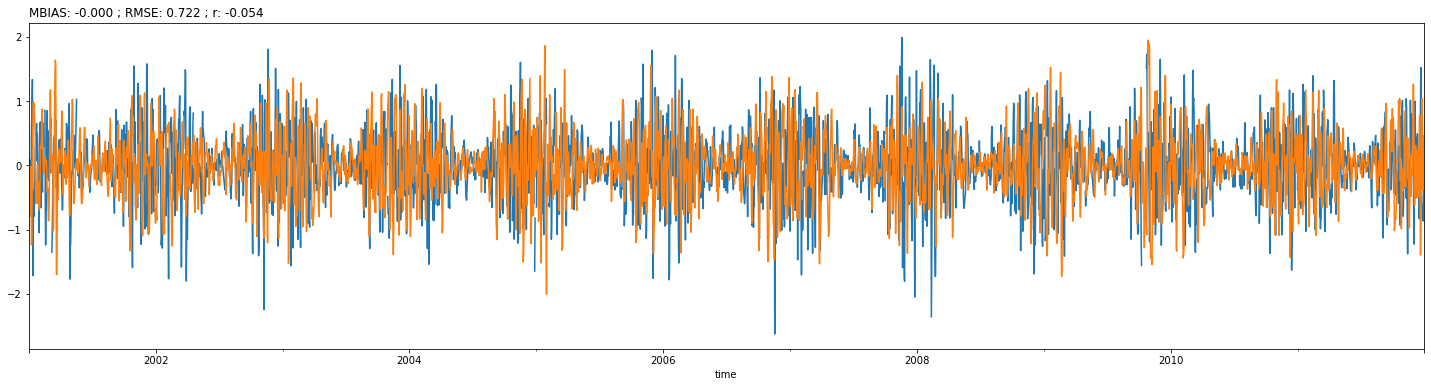

In [117]:
from scipy.stats import pearsonr
fig, ax = plt.subplots(1,1, figsize=(25,6))
pd.Series(filter_timeseries(sst_coquimbo, order=5, cutoff=1/30, btype='highpass'),index=sst_coquimbo.index).plot(ax=ax)
pd.Series(filter_timeseries(sstcroco_coquimbo, order=5, cutoff=1/30,btype='highpass'),index=sstcroco_coquimbo.index).plot(ax=ax)
ax.set_title('MBIAS: {:.3f} ; RMSE: {:.3f} ; r: {:.3f}'.format((pd.Series(filter_timeseries(sst_coquimbo, order=5, cutoff=1/30, btype='highpass'),index=sst_coquimbo.index)-pd.Series(filter_timeseries(sstcroco_coquimbo, order=5, cutoff=1/30,btype='highpass'),index=sstcroco_coquimbo.index)).mean(),
                                                            ((pd.Series(filter_timeseries(sst_coquimbo, order=5, cutoff=1/30, btype='highpass'),index=sst_coquimbo.index)-pd.Series(filter_timeseries(sstcroco_coquimbo, order=5, cutoff=1/30,btype='highpass'),index=sstcroco_coquimbo.index))**2).mean()**0.5,
                                                            pearsonr(pd.Series(filter_timeseries(sst_coquimbo, order=5, cutoff=1/30, btype='highpass'),index=sst_coquimbo.index).interpolate(), pd.Series(filter_timeseries(sstcroco_coquimbo, order=5, cutoff=1/30,btype='highpass'),index=sstcroco_coquimbo.index))[0]),
             loc='left')

Text(0.5, 0, '')

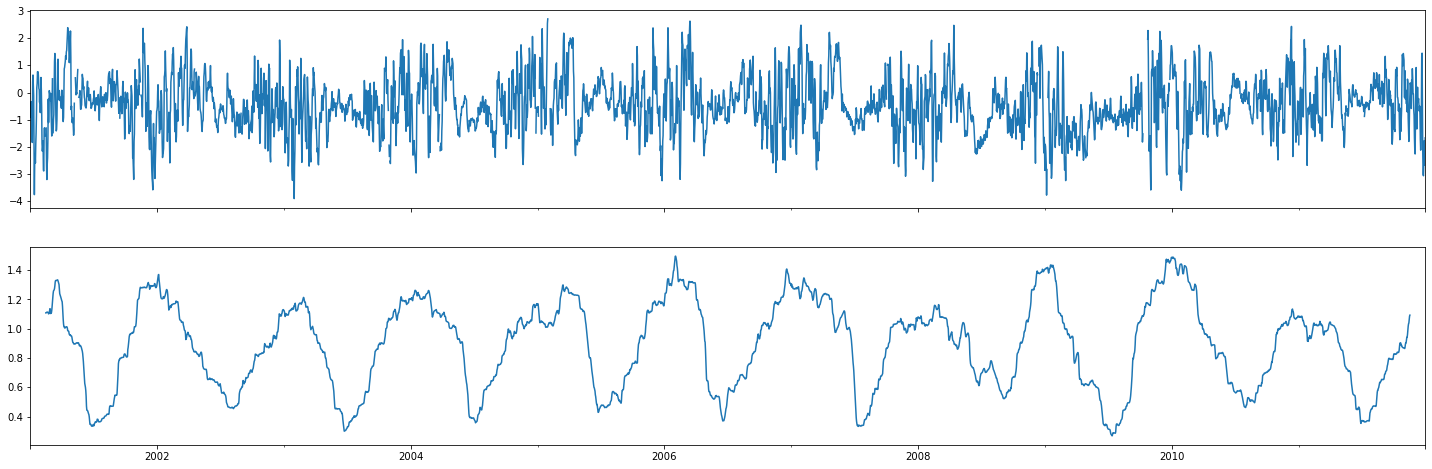

In [121]:
fig, ax = plt.subplots(2,1, figsize=(25,8), sharex=True)
(sst_coquimbo-sstcroco_coquimbo).plot(ax=ax[0])
(sst_coquimbo-sstcroco_coquimbo).interpolate().rolling(90, center=True).std().plot(ax=ax[1])

ax[0].set_xlabel('')
ax[1].set_xlabel('')